In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
data_dir = "./"
normal_file = os.path.join(data_dir, "WADI_14days_new.csv")
attack_file = os.path.join(data_dir, "WADI_attackdataLABLE.csv")

df_normal = pd.read_csv(normal_file)
df_normal["Label"] = 0  # All normal

df_attack = pd.read_csv(attack_file, low_memory=False, header=1)

df_normal.columns = df_normal.columns.str.strip()
df_attack.columns = df_attack.columns.str.strip()

last_col = df_attack.columns[-1]
df_attack["Label"] = df_attack[last_col].map({1: 0, -1: 1})  # Convert to 0 (normal), 1 (attack)
df_attack.drop(columns=[last_col], inplace=True)

print(df_attack.dtypes)


Row                         float64
Date                         object
Time                         object
1_AIT_001_PV                float64
1_AIT_002_PV                float64
                             ...   
3_P_004_STATUS              float64
LEAK_DIFF_PRESSURE          float64
PLANT_START_STOP_LOG        float64
TOTAL_CONS_REQUIRED_FLOW    float64
Label                         int64
Length: 131, dtype: object


In [ ]:
print("Normal Data Shape:", df_normal.shape)
print("Attack Data Shape:", df_attack.shape)

df_normal.head(2)
df_attack.head(2)


Normal Data Shape: (784571, 131)
Attack Data Shape: (172803, 131)


,Row,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,Label
0,1.0,10/9/17,00:00.0,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
1,2.0,10/9/17,00:01.0,164.21,0.529486,11.9972,482.48,0.331167,0.001273,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0


In [ ]:
cols_to_drop = ['Row', 'Date', 'Time']
df_normal.drop(columns=[col for col in cols_to_drop if col in df_normal.columns], inplace=True)
df_attack.drop(columns=[col for col in cols_to_drop if col in df_attack.columns], inplace=True)

df_all = pd.concat([df_normal, df_attack], ignore_index=True)


In [19]:
print(df_all.head())
print(df_all.shape)
df_all.dtypes

   1_AIT_001_PV  1_AIT_002_PV  1_AIT_003_PV  1_AIT_004_PV  1_AIT_005_PV  \
0       171.155      0.619473       11.5759       504.645      0.318319   
1       171.155      0.619473       11.5759       504.645      0.318319   
2       171.155      0.619473       11.5759       504.645      0.318319   
3       171.155      0.607477       11.5725       504.673      0.318438   
4       171.155      0.607477       11.5725       504.673      0.318438   

   1_FIT_001_PV  1_LS_001_AL  1_LS_002_AL  1_LT_001_PV  1_MV_001_STATUS  ...  \
0      0.001157          0.0          0.0      47.8911              1.0  ...   
1      0.001157          0.0          0.0      47.8911              1.0  ...   
2      0.001157          0.0          0.0      47.8911              1.0  ...   
3      0.001207          0.0          0.0      47.7503              1.0  ...   
4      0.001207          0.0          0.0      47.7503              1.0  ...   

   3_MV_002_STATUS  3_MV_003_STATUS  3_P_001_STATUS  3_P_002_STATUS 

1_AIT_001_PV                float64
1_AIT_002_PV                float64
1_AIT_003_PV                float64
1_AIT_004_PV                float64
1_AIT_005_PV                float64
                             ...   
3_P_004_STATUS              float64
LEAK_DIFF_PRESSURE          float64
PLANT_START_STOP_LOG        float64
TOTAL_CONS_REQUIRED_FLOW    float64
Label                         int64
Length: 128, dtype: object

In [ ]:
# Feature/label split
X = df_all.drop(columns=["Label"])
y = df_all["Label"]

# Convert all features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

X = X.ffill()
X.dropna(axis=1, how='all', inplace=True)

X.dropna(thresh=int(0.9 * X.shape[1]), inplace=True)  # keep row if >=90% non-NaN

# Align labels with final X
y = y.loc[X.index]

In [24]:
print("Rows after cleanup:", X.shape[0])
print("Remaining columns:", X.shape[1])
print("Label distribution:\n", y.value_counts())


Rows after cleanup: 957374
Remaining columns: 123
Label distribution:
 Label
0    947397
1      9977
Name: count, dtype: int64


In [23]:
# Train-Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Class distribution in train set:\n", y_train.value_counts(normalize=True))


Train set size: (765899, 123)
Test set size: (191475, 123)
Class distribution in train set:
 Label
0    0.989578
1    0.010422
Name: proportion, dtype: float64


In [ ]:
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


Training Random Forest...


In [ ]:
# Compute scale_pos_weight = ratio of normal to attack in training data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


Training XGBoost...


/home/hridai/programs/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:49:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluation for {model_name}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
    print("ROC-AUC Score:", roc_auc_score(y_true, y_pred))

evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, xgb_preds, "XGBoost")



📋 Evaluation for Random Forest
Confusion Matrix:
 [[189473      7]
 [     3   1992]]
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    189480
           1     0.9965    0.9985    0.9975      1995

    accuracy                         0.9999    191475
   macro avg     0.9982    0.9992    0.9987    191475
weighted avg     0.9999    0.9999    0.9999    191475

ROC-AUC Score: 0.99922964869425

📋 Evaluation for XGBoost
Confusion Matrix:
 [[189471      9]
 [     3   1992]]
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    189480
           1     0.9955    0.9985    0.9970      1995

    accuracy                         0.9999    191475
   macro avg     0.9977    0.9992    0.9985    191475
weighted avg     0.9999    0.9999    0.9999    191475

ROC-AUC Score: 0.9992243710923921


In [ ]:
joblib.dump(rf, "rf_model.pkl")
joblib.dump(xgb, "xgb_model.pkl")

print("Models saved as rf_model.pkl and xgb_model.pkl")

Models saved as rf_model.pkl and xgb_model.pkl


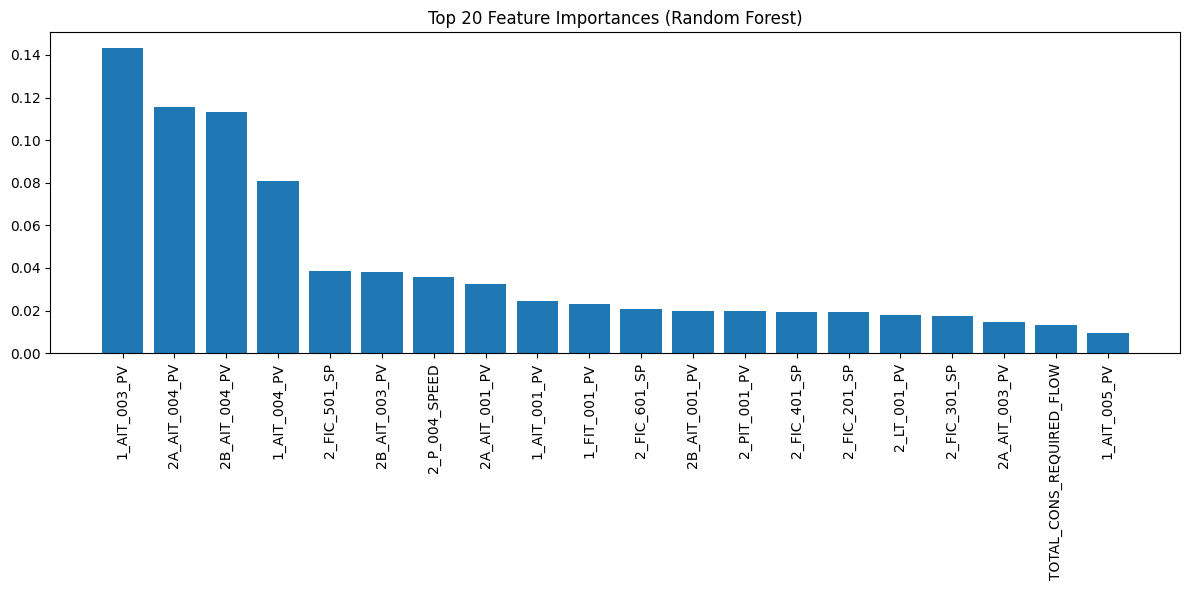

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20
features = X.columns[indices][:top_n]


plt.figure(figsize=(12, 6))
plt.bar(range(top_n), importances[indices][:top_n], align='center')
plt.xticks(range(top_n), features, rotation=90)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


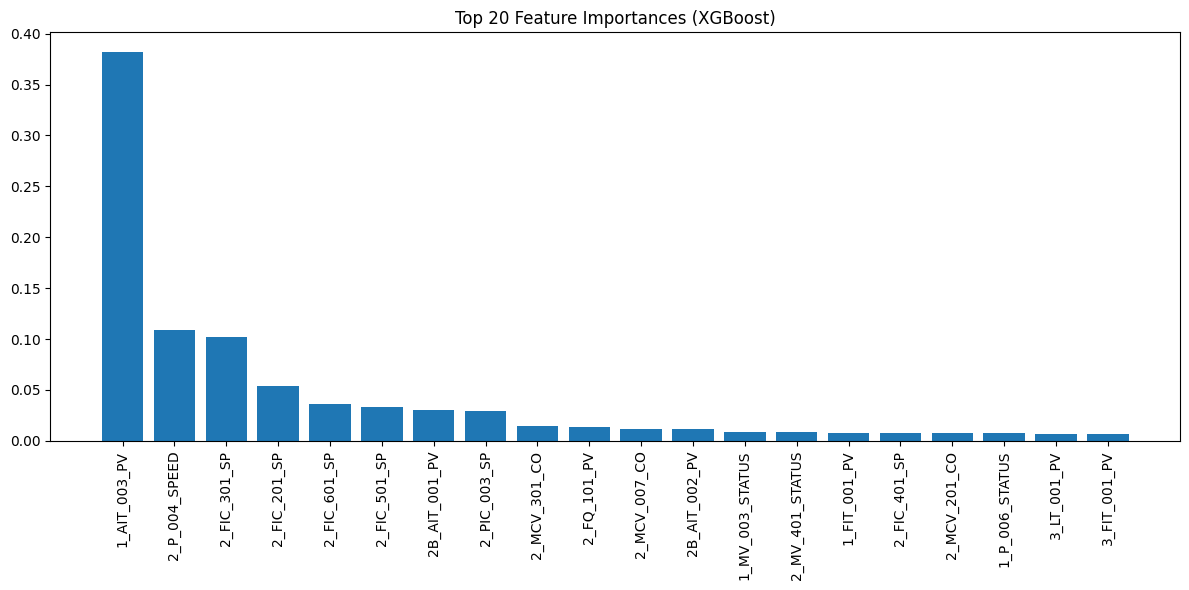

In [31]:
xgb_importances = xgb.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]
xgb_top_n = 20
xgb_features = X.columns[xgb_indices][:xgb_top_n]

plt.figure(figsize=(12, 6))
plt.bar(range(xgb_top_n), xgb_importances[xgb_indices][:xgb_top_n], align='center')
plt.xticks(range(xgb_top_n), xgb_features, rotation=90)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


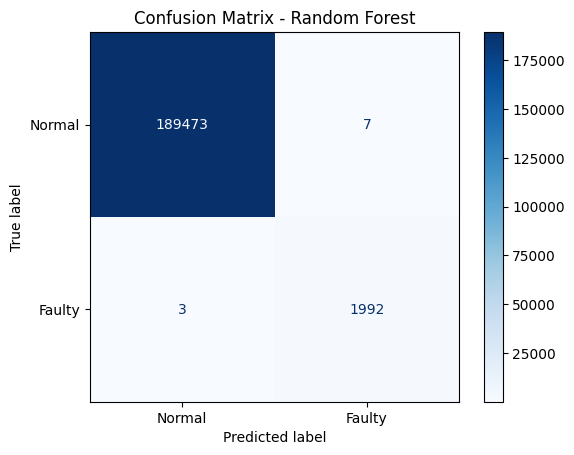

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    rf, X_test, y_test, display_labels=["Normal", "Faulty"], cmap="Blues"
)
plt.title("Confusion Matrix - Random Forest")
plt.show()


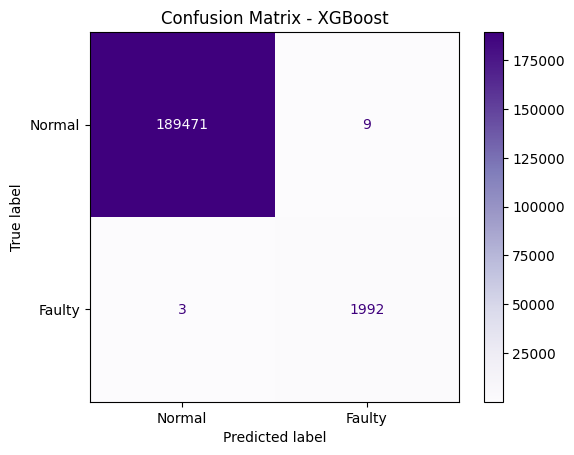

In [33]:
ConfusionMatrixDisplay.from_estimator(
    xgb, X_test, y_test, display_labels=["Normal", "Faulty"], cmap="Purples"
)
plt.title("Confusion Matrix - XGBoost")
plt.show()


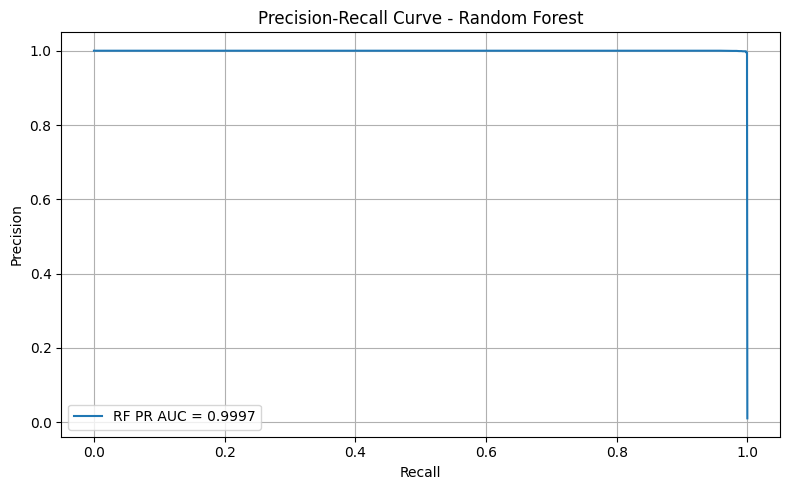

In [34]:
from sklearn.metrics import precision_recall_curve, auc

rf_probs = rf.predict_proba(X_test)[:, 1]
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
rf_pr_auc = auc(rf_recall, rf_precision)

plt.figure(figsize=(8, 5))
plt.plot(rf_recall, rf_precision, label=f"RF PR AUC = {rf_pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


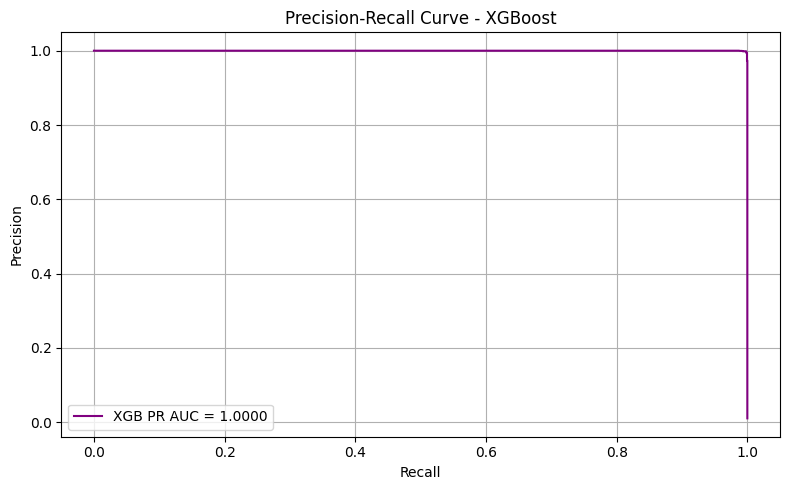

In [35]:
xgb_probs = xgb.predict_proba(X_test)[:, 1]
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_pr_auc = auc(xgb_recall, xgb_precision)

plt.figure(figsize=(8, 5))
plt.plot(xgb_recall, xgb_precision, color='purple', label=f"XGB PR AUC = {xgb_pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


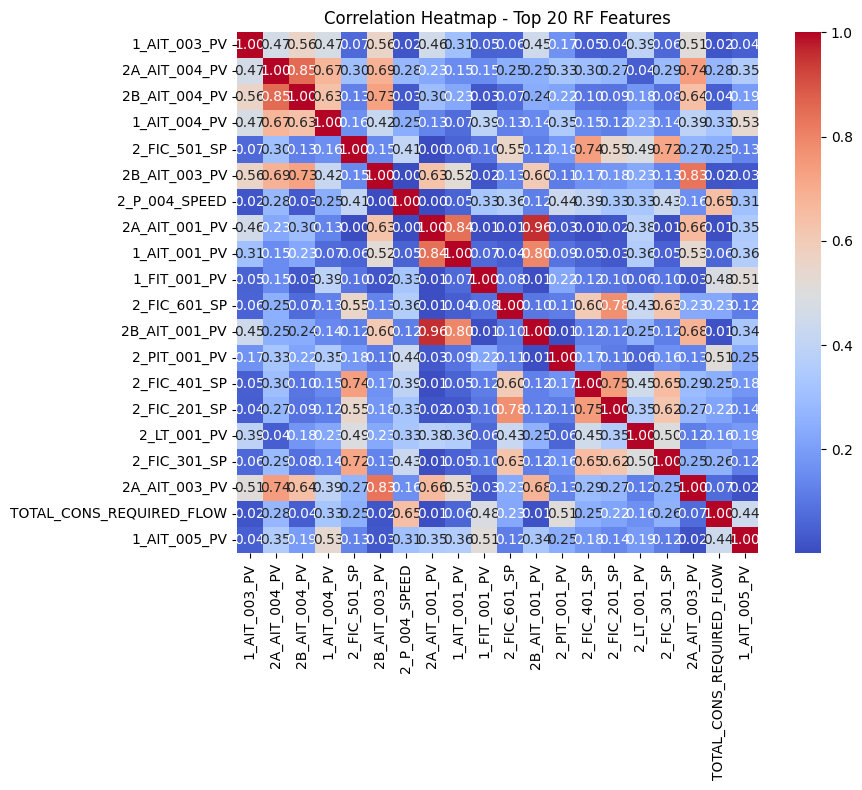

In [ ]:
# Recalculate top 20 RF features by importance
rf_importances = rf.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]
rf_features = X.columns[rf_indices][:20]

# Correlation heatmap
top_rf_corr = X[rf_features].corr().abs()

plt.figure(figsize=(10, 8))
sns.heatmap(top_rf_corr, cmap="coolwarm", annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap - Top 20 RF Features")
plt.tight_layout()
plt.show()


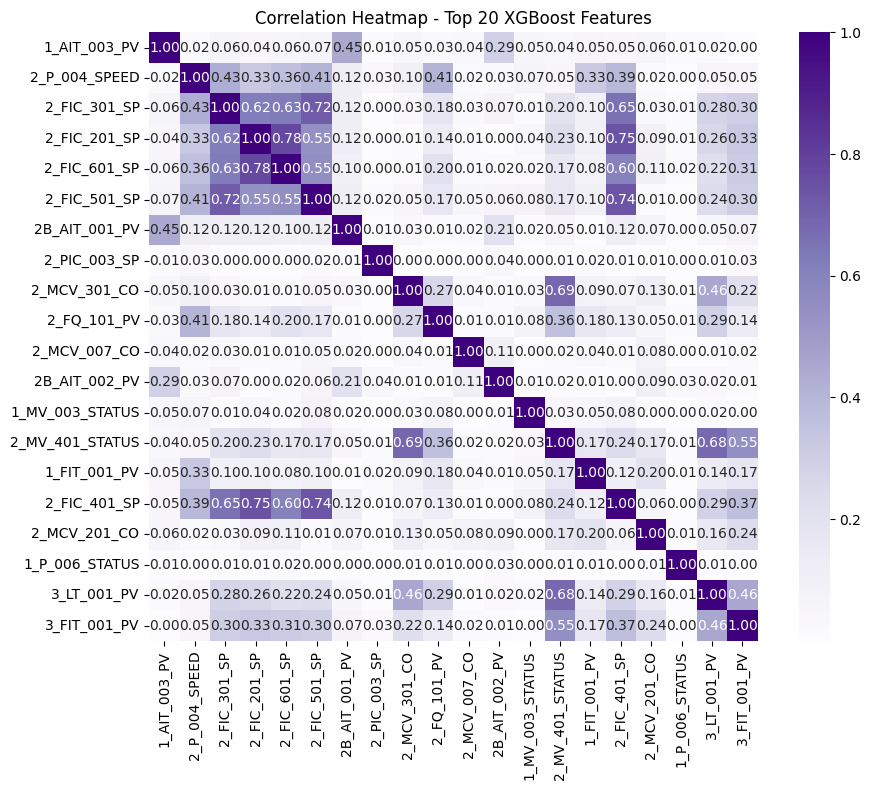

In [ ]:
# Recalculate top 20 XGB features by importance
xgb_importances = xgb.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]
xgb_features = X.columns[xgb_indices][:20]

# Correlation heatmap
top_xgb_corr = X[xgb_features].corr().abs()

plt.figure(figsize=(10, 8))
sns.heatmap(top_xgb_corr, cmap="Purples", annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap - Top 20 XGBoost Features")
plt.tight_layout()
plt.show()
